# Demo for ISPC.jl

Runs the Mandelbrot ISPC example entirely from Julia code.

In [1]:
using ISPC

Linker: /usr/bin/libtool


This is the function we will call for every pixel. Declare it `@inline` so that the `@kernel` below can use it.

In [2]:
@inline function mandel(c_re, c_im, count)
    z_re = c_re
    z_im = c_im
    i = 0
    while i < count
        if (z_re * z_re + z_im * z_im > 4.0f0)
            break
        end
        new_re = z_re*z_re - z_im*z_im
        new_im = 2.0f0 * z_re * z_im
        z_re = c_re + new_re
        z_im = c_im + new_im
        i += 1
    end
    return i
end

mandel (generic function with 1 method)

This is the main function. Tag it with `@ispc` so that all kernel fragments inside are extracted and compiled separately by ISPC.

In [3]:
@ispc function mandelbrot_ispc(x0, y0, x1, y1, output, max_iters)
    height, width = size(output)
    dx = (x1 - x0) / width
    dy = (y1 - y0) / height
    @kernel(`--target=avx1-i32x16`) do
        for i = 0:width-1
            @foreach(0:height-1) do j
                x = x0 + i * dx
                y = y0 + j * dy
                output[j, i] = mandel(x, y, max_iters)
            end
        end
    end
    output
end;

Extracted kernel Val{symbol("##8014")}((:x0,:y0,:output,:max_iters,:height,:width,:dx,:dy))
begin 
    GenSym(3) = (Main.colon)(0,((top(getfield))(Base.FastMath,:sub_fast))(width,1))
    #s40 = (top(start))(GenSym(3))
    unless (top(!))((top(done))(GenSym(3),#s40)) goto 1
    2: 
    GenSym(4) = (top(next))(GenSym(3),#s40)
    i = (top(getfield))(GenSym(4),1)
    #s40 = (top(getfield))(GenSym(4),2)
    $(Expr(:meta, :ispc, symbol("##foreach#8022"), :foreach, (:(0:Base.FastMath.sub_fast(height,1)),)))
    j = (ISPC.foreachindex)(1,(Main.colon)(0,((top(getfield))(Base.FastMath,:sub_fast))(height,1)))
    x = ((top(getfield))(Base.FastMath,:add_fast))(x0,((top(getfield))(Base.FastMath,:mul_fast))(i,dx))
    y = ((top(getfield))(Base.FastMath,:add_fast))(y0,((top(getfield))(Base.FastMath,:mul_fast))(j,dy))
    GenSym(5) = (Main.mandel)(x,y,max_iters)
    (Main.setindex!)(output,GenSym(5),j,i)
    $(Expr(:meta, :ispc, symbol("##foreach#8022")))
    3: 
    unless (top(!))((top(!))((top(don

In [4]:
output = zeros(Float32, 768, 1024);

Check that kernel fragments in the main Julia function have been replaced by kernel calls:

In [5]:
@code_lowered mandelbrot_ispc(-2.0f0, -1.0f0, 1.0f0, 1.0f0, output, 256)

1-element Array{Any,1}:
 :($(Expr(:lambda, Any[:x0,:y0,:x1,:y1,:output,:max_iters], Any[Any[Any[:x0,:Any,1],Any[:y0,:Any,1],Any[:x1,:Any,0],Any[:y1,:Any,0],Any[:output,:Any,1],Any[:max_iters,:Any,1],Any[:height,:Any,19],Any[:width,:Any,19],Any[symbol("#s41"),:Any,2],Any[:dx,:Any,19],Any[:dy,:Any,19]],Any[],6,Any[]], :(begin  # In[3], line 2:
        NewvarNode(:height)
        NewvarNode(:width)
        NewvarNode(:dx)
        NewvarNode(:dy)
        GenSym(0) = (Main.size)(output)
        #s41 = (top(start))(GenSym(0))
        GenSym(1) = (top(indexed_next))(GenSym(0),1,#s41)
        height = (top(getfield))(GenSym(1),1)
        #s41 = (top(getfield))(GenSym(1),2)
        GenSym(2) = (top(indexed_next))(GenSym(0),2,#s41)
        width = (top(getfield))(GenSym(2),1)
        #s41 = (top(getfield))(GenSym(2),2) # In[3], line 3:
        dx = (x1 - x0) / width # In[3], line 4:
        dy = (y1 - y0) / height # In[3], line 5: # /Users/plantagenet/.julia/v0.5/ISPC.jl/src/macros.jl, line 141:

Calling the main function the first time will trigger the compilation of all its fragments:

In [6]:
mandelbrot_ispc(-2.0f0, -1.0f0, 1.0f0, 1.0f0, output, 256);

Generating kernel ##8014 for argument types (Float32,Float32,Array{Float32,2},Int64,Int64,Int64,Float32,Float32)
Compile options: `--target=avx1-i32x16`
Running type inference...
Lambda function:
	 arguments: Any[:x0,:y0,:output,:max_iters,:height,:width,:dx,:dy]
	 local variables: 
		(symbol("#s40"),Int64,2)
		(:i,Int64,18)
		(:j,Int64,18)
		(:x,Float32,18)
		(:y,Float32,18)
		(:x0,Float32,0)
		(:y0,Float32,0)
		(:output,Array{Float32,2},0)
		(:max_iters,Int64,0)
		(:height,Int64,18)
		(:width,Int64,18)
		(:dx,Float32,18)
		(:dy,Float32,18)
		(symbol("##ys#8508"),Tuple{Int64},0)
		(symbol("##ys#8509"),Tuple{Int64},0)
		(symbol("##zs#8510"),Tuple{},0)
		(symbol("##zs#8511"),Tuple{},0)
		(symbol("##z_re#8512"),Float32,2)
		(symbol("##z_im#8513"),Float32,2)
		(symbol("##i#8514"),Int64,2)
		(symbol("##new_re#8515"),Float32,18)
		(symbol("##new_im#8516"),Float32,18)
		(symbol("####xs#8507#8517"),Tuple{},0)
		(symbol("##I#8518"),Tuple{},0)
	 closure variables: 

	 SSA types: Any[Union{},Uni

ld: warning: -macosx_version_min not specified, assuming 10.10


Loaded function ispc_func_1 at Ptr{Void} @0x0000000311b78030


Now let's call it again to get an accurate measure of execution time:

In [7]:
x0, x1 = -2.1f0, 0.8f0
y0, y1 = -1.2f0, 1.2f0
@time out = mandelbrot_ispc(x0, y0, x1, y1, output, 256);

  0.091559 seconds (166 allocations: 10.714 KB)


Plot the generated fractal:

In [8]:
using PyPlot

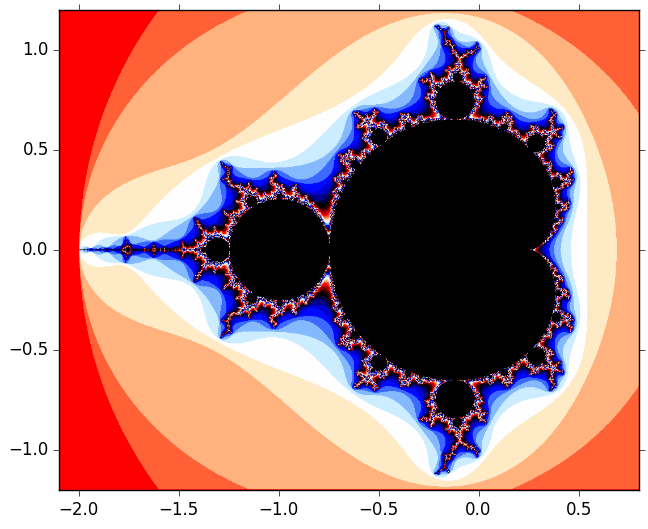

In [9]:
imshow(out, cmap="flag", aspect="equal", extent=(x0, x1, y0, y1))
display(gcf())
close()

Wow, nice!

Pure-Julia version for comparison. Note how it uses the same `mandel()` routine as the ISPC version. We can't use `@simd` here because of the branch statements.

In [10]:
@fastmath function mandelbrot_julia(x0, y0, x1, y1, output, max_iters)
    height, width = size(output)
    dx = (x1 - x0) / width
    dy = (y1 - y0) / height
    @inbounds begin
        for i = 1:width
            for j = 1:height
                x = x0 + i * dx
                y = y0 + j * dy
                output[j, i] = mandel(x, y, max_iters)
            end
        end
    end
    output
end

mandelbrot_julia (generic function with 1 method)

How fast does it run?

In [11]:
@time out = mandelbrot_julia(x0, y0, x1, y1, output, 256);

  0.243465 seconds (10.46 k allocations: 482.438 KB)


Not bad, only about 2.5x to 3x slower. But we got a decent speedup from ISPC!

Let's look at the generated C code, x86 assembly and LLVM assembly.

In [12]:
func = ISPC.ispc_funcs[end];

In [13]:
func_code = ISPC.gen_code(func)
println(func_code)

// Use ISPC's multiple dispatch capabilities to deal with the fact
// that Julia uses the same function for bitwise and boolean NOT,
// whereas the ~ operator in ISPC does not work on booleans:
inline bool __not(bool val) {return !val;} // boolean NOT
inline int8 __not(int8 val) {return ~val;} // all others are bitwise
inline int16 __not(int16 val) {return ~val;}
inline int32 __not(int32 val) {return ~val;}
inline int64 __not(int64 val) {return ~val;}
inline unsigned int8 __not(unsigned int8 val) {return ~val;}
inline unsigned int16 __not(unsigned int16 val) {return ~val;}
inline unsigned int32 __not(unsigned int32 val) {return ~val;}
inline unsigned int64 __not(unsigned int64 val) {return ~val;}


struct UnitRange {
    int64 start;
    int64 stop;
};
export void ispc_func_1(uniform float x0, uniform float y0, uniform float output[], uniform int64 output__len__1, uniform int64 output__len__2, uniform int64 max_iters, uniform int64 height, uniform int64 width, uniform float dx, uniform

In [14]:
ISPC.ispc_native(func_code, func.file.compile_opts)

	.section	__TEXT,__text,regular,pure_instructions
	.macosx_version_min 13, 4
	.section	__TEXT,__literal16,16byte_literals
	.align	4
LCPI0_0:
	.long	0                       ## 0x0
	.long	1                       ## 0x1
	.long	2                       ## 0x2
	.long	3                       ## 0x3
LCPI0_1:
	.long	4                       ## 0x4
	.long	5                       ## 0x5
	.long	6                       ## 0x6
	.long	7                       ## 0x7
LCPI0_2:
	.long	8                       ## 0x8
	.long	9                       ## 0x9
	.long	10                      ## 0xa
	.long	11                      ## 0xb
LCPI0_3:
	.long	12                      ## 0xc
	.long	13                      ## 0xd
	.long	14                      ## 0xe
	.long	15                      ## 0xf
LCPI0_4:
	.byte	0                       ## 0x0
	.byte	1                       ## 0x1
	.byte	4                       ## 0x4
	.byte	5                       ## 0x5
	.byte	8                       ## 0x8
	.byte	9                 

2409

m2 = xmm3[0,1,2],xmm2[0]
	vpextrq	$1, %xmm13, %rdx
	vcvtsi2ssq	%rdx, %xmm0, %xmm3
	vmovq	%xmm13, %rdx
	vcvtsi2ssq	%rdx, %xmm0, %xmm4
	vinsertps	$16, %xmm3, %xmm4, %xmm3 ## xmm3 = xmm4[0],xmm3[0],xmm4[2,3]
	vmovq	%xmm10, %rdx
	vcvtsi2ssq	%rdx, %xmm0, %xmm4
	vinsertps	$32, %xmm4, %xmm3, %xmm3 ## xmm3 = xmm3[0,1],xmm4[0],xmm3[3]
	vpextrq	$1, %xmm10, %rdx
	vcvtsi2ssq	%rdx, %xmm0, %xmm4
	vinsertps	$48, %xmm4, %xmm3, %xmm3 ## xmm3 = xmm3[0,1,2],xmm4[0]
	leal	(%rcx,%rax), %edx
	shll	$2, %edx
	movslq	%edx, %rdx
	vmovups	%xmm3, (%rdi,%rdx)
	vmovups	%xmm2, 16(%rdi,%rdx)
	vmovups	%xmm1, 32(%rdi,%rdx)
	vmovups	%xmm0, 48(%rdi,%rdx)
	addl	$16, %ecx
	cmpl	%r15d, %ecx
	jl	LBB1_4
LBB1_11:                                ## %partial_inner_all_outer
                                        ##   in Loop: Header=BB1_1 Depth=1
	leaq	1(%r14), %r11
	cmpl	%r10d, %ecx
	vmovups	224(%rsp), %ymm2        ## 32-byte Reload
	vmovups	192(%rsp), %ymm1        ## 32-byte Reload
	jge	LBB1_1
## BB#12:                        

In [15]:
ISPC.ispc_llvm(func_code, func.file.compile_opts)

; ModuleID = '<stdin>'
target datalayout = "e-m:o-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-apple-darwin13.4.0"

; Function Attrs: nounwind readnone
declare i32 @llvm.x86.avx.movmsk.ps.256(<8 x float>) #0

; Function Attrs: nounwind
declare void @llvm.x86.avx.maskstore.ps.256(i8*, <8 x float>, <8 x float>) #1

; Function Attrs: nounwind readnone
declare <8 x float> @llvm.x86.avx.blendv.ps.256(<8 x float>, <8 x float>, <8 x float>) #0

; Function Attrs: nounwind readnone
declare <4 x double> @llvm.x86.avx.blendv.pd.256(<4 x double>, <4 x double>, <4 x double>) #0

; Function Attrs: nounwind
define void @ispc_func_1___unfunfun_3C_unf_3E_unIunIunIunIunIunfunf(float %x0, float %y0, float* noalias nocapture %output, i64 %output__len__1, i64 %output__len__2, i64 %max_iters, i64 %height, i64 %width, float %dx, float %dy, <16 x i32> %__mask) #1 {
allocas:
  %floatmask.i = bitcast <16 x i32> %__mask to <16 x float>
  %mask0.i = shufflevector <16 x float> %floatmask.i, <16 x float

2409

8 x float> %blend1.i.i853, <16 x i32> <i32 0, i32 1, i32 2, i32 3, i32 4, i32 5, i32 6, i32 7, i32 8, i32 9, i32 10, i32 11, i32 12, i32 13, i32 14, i32 15>
  %add___i_8514_load220_ = add <16 x i64> %3, <i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1, i64 1>
  %old0d.i = shufflevector <16 x double> %.ph970, <16 x double> undef, <4 x i32> <i32 0, i32 1, i32 2, i32 3>
  %old1d.i = shufflevector <16 x double> %.ph970, <16 x double> undef, <4 x i32> <i32 4, i32 5, i32 6, i32 7>
  %old2d.i = shufflevector <16 x double> %.ph970, <16 x double> undef, <4 x i32> <i32 8, i32 9, i32 10, i32 11>
  %old3d.i = shufflevector <16 x double> %.ph970, <16 x double> undef, <4 x i32> <i32 12, i32 13, i32 14, i32 15>
  %new.i = bitcast <16 x i64> %add___i_8514_load220_ to <16 x double>
  %new0d.i = shufflevector <16 x double> %new.i, <16 x double> undef, <4 x i32> <i32 0, i32 1, i32 2, i32 3>
  %new1d.i = shufflevector <16 x double> %new.i, <16 x doub